In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
# 
PATH = os.path.abspath(os.path.join('drive', 'My Drive', 'engr489-2019', 'kun', 'models', 'ae_hdbscan'))
sys.path.append(PATH)
sys.path.append(PATH+'/..')

OUTPUT_DIR = PATH+'/ae_hdbscan_v1_2019.04.09-11:54:40_output'
print(OUTPUT_DIR)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/engr489-2019/kun/models/ae_hdbscan/ae_hdbscan_v1_2019.04.09-11:54:40_output


### Loading the dataset and model

In [2]:
import numpy as np

import torch
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter


from ae.ae import AutoEncoder
from utils.datasets import FilteredMNIST

SEED = 489
torch.manual_seed(SEED)    # reproducible
np.random.seed(SEED)


ae = AutoEncoder()  
dataset = FilteredMNIST(output_dir=OUTPUT_DIR)
model_path = ae.load_model(output_dir=OUTPUT_DIR)


Loaded filtered_mnist.pt from content

Loading model...
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=2000, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=2000, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=500, out_features=784, bias=True)
    (7): Sigmoid()
  )
  (loss_fn): BCELoss()
)

Loaded model	ae_hdbscan_v1_2019.04.09-11:54:40.pth

Batch size: 128 LR: 0.001 Optimiser: Adam

Epoch: 34	Loss: 0.05780987814068794



In [0]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

def plt_scatter(feat=[], labels=[], colors_list=[], plt_centroids=False, plt_name=''):
  palette = sns.color_palette('hls', np.unique(labels).max() +1)
  colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]    # -1 is noise
  ax = plt.subplot()
  ax.tick_params(axis='both', labelsize=10)
  
  if len(colors_list) == 0:
    plt.scatter(*feat.T, c=colors, s=8, linewidths=1)
  else:
    plt.scatter(*feat[0].T, c=colors, s=8, linewidths=1)
    for i, f in enumerate(feat[1:]):
      plt.scatter(*f.T, c=colors_list[i], s=8, linewidths=1)
    feat = feat[0]

  if plt_centroids:
    centroids = np.array([np.median(feat[labels == label], axis=0) for label in np.unique(labels[labels!=-1])])
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, alpha=0.5)
  else:
    for label in np.unique(labels[labels!=-1]):   
        xtext, ytext = np.median(feat[labels == label], axis=0)
        txt = ax.text(xtext, ytext, str(label), fontsize=18)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])

  if plt_name!='':
      plt.savefig(OUTPUT_DIR+'/_{}.png'.format(plt_name), bbox_inches='tight')
      print('Saved '+OUTPUT_DIR+'/_{}.png'.format(plt_name))

In [3]:
 _, feat, labels, test_imgs = ae.eval_model(dataset=dataset, 
                                batch_size=ae.BATCH_SIZE, 
                                epoch=ae.EPOCH, 
                                output_dir=OUTPUT_DIR)

====> Test set loss: 0.0651



In [17]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print(feat.size())
print(dataset.test.targets.unique()) 
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, random_state=SEED)
feat = tsne.fit_transform(feat.numpy())
print(feat.shape)

feat_std = StandardScaler().fit_transform(feat)    # Normalise the data
feat_minmax = MinMaxScaler().fit_transform(feat) 

TypeError: ignored

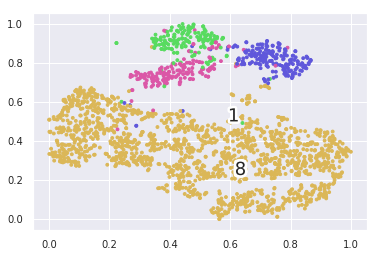

In [14]:
plt_scatter(feat_minmax, labels)

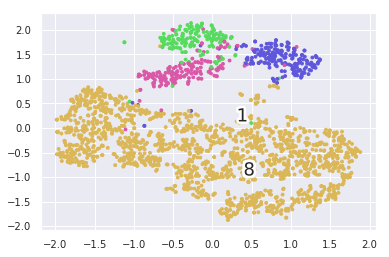

In [16]:
plt_scatter(feat_std, labels)

In [0]:
feat = feat_minmax

### HDBSCAN Plots

In [19]:
!pip install hdbscan
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
hdbscan.fit(feat)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
        prediction_data=False)

In [20]:
h_labels = hdbscan.labels_
print(np.unique(h_labels), h_labels.shape)

[-1  0  1  2] (2101,)


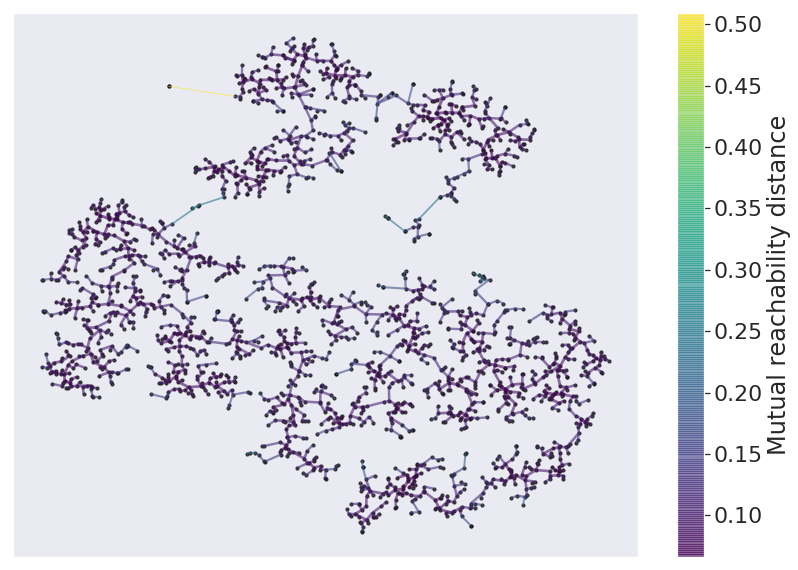

In [7]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure


plt.figure(figsize=(14, 10))
hdbscan.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=10, 
                                      edge_linewidth=1)
plt.savefig(OUTPUT_DIR+'/_HDBSCAN_min_span_tree.png', bbox_inches='tight')

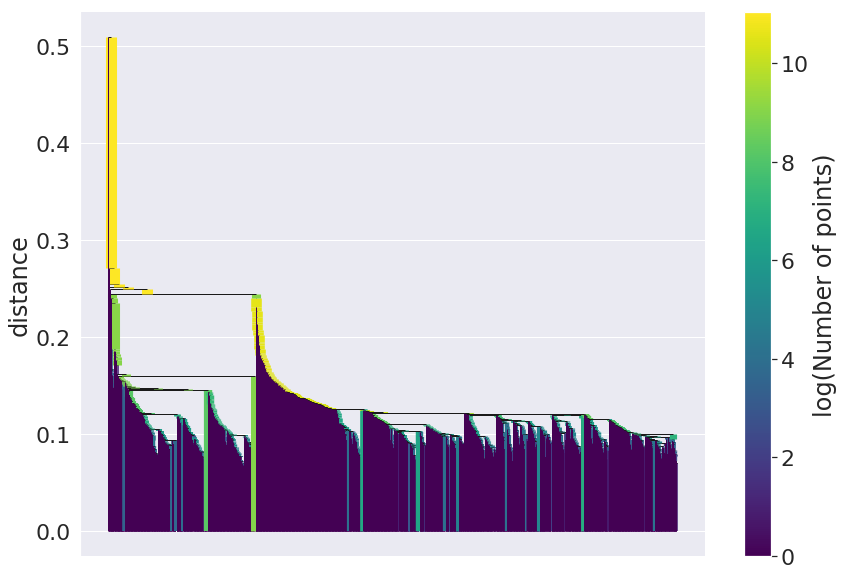

In [8]:
plt.figure(figsize=(14, 10))
hdbscan.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.savefig(OUTPUT_DIR+'/_HDBSCAN_single_linkage_tree.png', bbox_inches='tight')

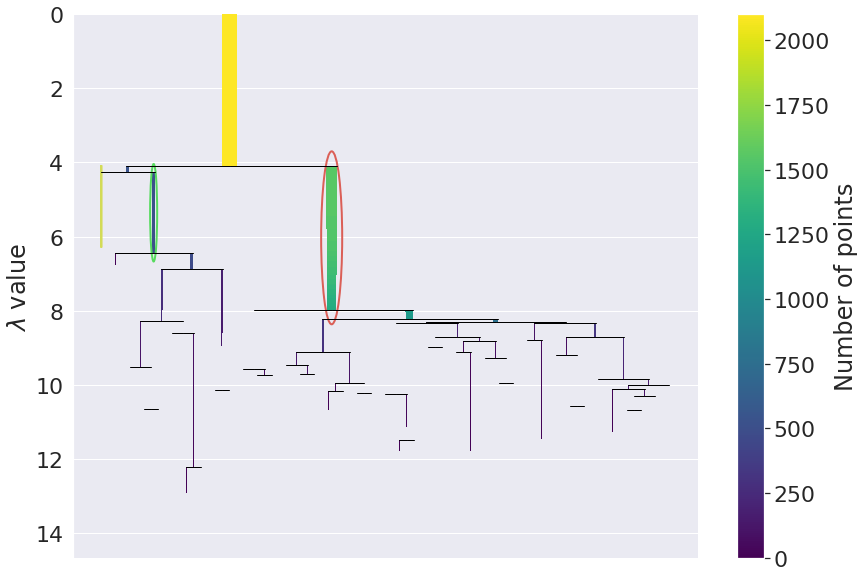

In [9]:
plt.figure(figsize=(14, 10))
hdbscan.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('hls'))
plt.savefig(OUTPUT_DIR+'/_HDBSCAN_condensed_tree.png', bbox_inches='tight')


### Finding the centroid 

Saved /content/drive/My Drive/engr489-2019/kun/models/ae_hdbscan/ae_hdbscan_v1_2019.04.09-11:54:40_output/_HDBSCAN_clusters.png


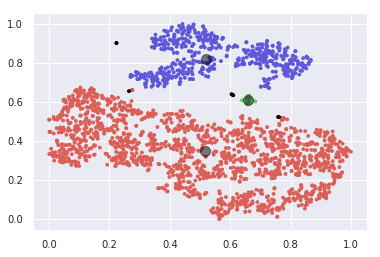

In [21]:
plt_scatter(feat, h_labels, plt_centroids=True, plt_name='HDBSCAN_clusters')

Saved /content/drive/My Drive/engr489-2019/kun/models/ae_hdbscan/ae_hdbscan_v1_2019.04.09-11:54:40_output/_HDBSCAN_clusters.png


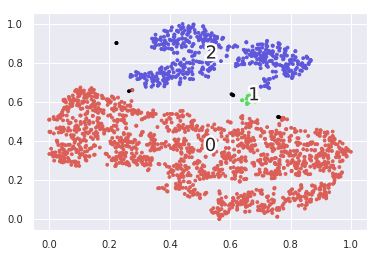

In [22]:
plt_scatter(feat, h_labels, plt_centroids=False, plt_name='HDBSCAN_clusters')

### Ordering centroid from largest to smallest

In [23]:
h_labels_clean = h_labels[h_labels!=-1] # Remove noise label
cluster_size = [(label, len(h_labels_clean[h_labels_clean==label])) for label in np.unique(h_labels_clean)]
cluster_size = sorted(cluster_size, key=lambda x:(x[1]))[::-1]
cluster_size

[(0, 1558), (2, 522), (1, 12)]

In [24]:
lut = np.array([c[0] for c in cluster_size])
print(lut)
print(h_labels_clean)
# # h_labels_clean = lut[h_labels_clean]
# centroids = centroids[lut]
print(lut[h_labels_clean])

[0 2 1]
[0 0 2 ... 0 2 0]
[0 0 1 ... 0 1 0]


Saved /content/drive/My Drive/engr489-2019/kun/models/ae_hdbscan/ae_hdbscan_v1_2019.04.09-11:54:40_output/_HDBSCAN_clusters_clean.png


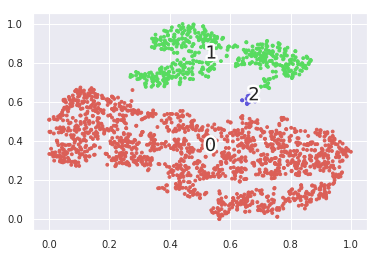

In [25]:
plt_scatter(feat[h_labels!=-1], lut[h_labels_clean], plt_centroids=False, plt_name='HDBSCAN_clusters_clean')

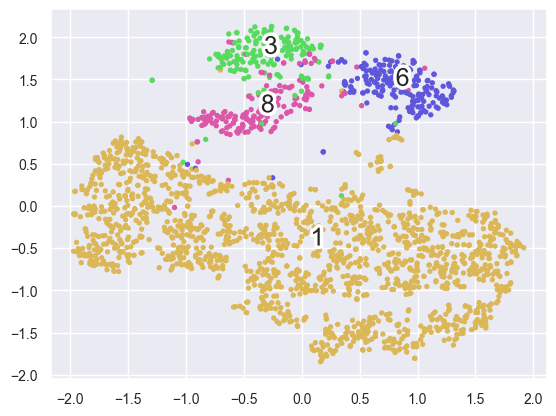

In [26]:
import cv2 as cv
from google.colab.patches import cv2_imshow

true = cv.imread(OUTPUT_DIR+'/tsne_{}.png'.format(ae.EPOCH))
cv2_imshow(true)

### Finding the closest imgs to centroid

In [27]:
from sklearn.metrics import pairwise_distances_argmin_min

# centroids = [0, 1, 2] biggest to smallest

centroids = np.array([np.median(feat[h_labels == label], axis=0) for label in np.unique(h_labels[h_labels!=-1])])
centroids = centroids[lut]
centroid_imgs_idx, _ = pairwise_distances_argmin_min(centroids, feat)
print(test_imgs.size())
print(centroid_imgs_idx)

torch.Size([2101, 784])
[759 906 292]


torch.Size([3, 784])
torch.Size([3, 1, 28, 28])


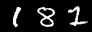

In [28]:
import cv2 as cv
from google.colab.patches import cv2_imshow

centroid_imgs =  test_imgs[centroid_imgs_idx]

print(centroid_imgs.size())
centroid_imgs = centroid_imgs.view(-1, 1, 28, 28)
print(centroid_imgs.size())
save_image(centroid_imgs, OUTPUT_DIR+'/_HDBSCAN_centroid_imgs.png')


centroid_imgs_png = cv.imread(OUTPUT_DIR+'/_HDBSCAN_centroid_imgs.png')
cv2_imshow(centroid_imgs_png)


### Outlier Detection

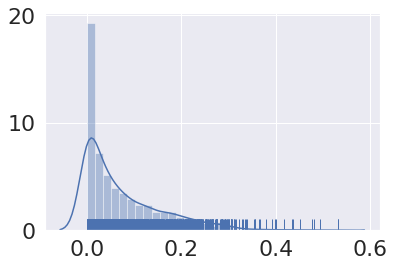

In [29]:
outliers = hdbscan.outlier_scores_

sns.distplot(outliers[np.isfinite(outliers)], rug=True)
plt.savefig(OUTPUT_DIR+'_HDBSCAN_outlier_dist.png', bbox_inches='tight')

#### Sample outliers

210
210
191 9
198
Saved /content/drive/My Drive/engr489-2019/kun/models/ae_hdbscan/ae_hdbscan_v1_2019.04.09-11:54:40_output/_HDBSCAN_outliers.png


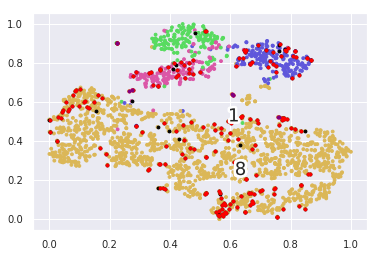

In [197]:
import random
outliers = hdbscan.outlier_scores_

threshold = pd.Series(outliers).quantile(0.90)
outliers_thld = np.where(outliers > threshold)[0]
print(len(np.unique(outliers_thld)))

noise_idx = np.where(h_labels==-1)[0]  # Noise labels
outliers_thld = np.delete(outliers_thld, np.where(outliers_thld == noise_idx), axis=0)
print(len(np.unique(outliers_thld)))

sample_idx = random.sample(set(outliers_thld), 200-len(noise_idx))
print(len(np.unique(sample_idx)), len(noise_idx))

sample_idx = np.append(noise_idx, sample_idx)
print(len(np.unique(sample_idx)))
plt_scatter([feat, feat[outliers_thld], feat[sample_idx], feat[noise_idx]], labels, colors_list=['black', 'red', 'purple'], plt_name='HDBSCAN_outliers')

In [200]:
print(sample_idx)

encoded, decoded = ae.forward(test_imgs[sample_idx].view(-1, 784).to(ae.device))
outlier_feat = tsne.fit_transform(encoded.cpu().detach().numpy())
print(outlier_feat.shape)

outlier_feat = MinMaxScaler().fit_transform(outlier_feat)    # Normalise the data

[  51  125  762  999 1062 1182 1464 1603 1746  237  887 1543  555  860
 1140 1221 1252 1948 1827 1690  590  840 1717  496 1316 1734  798  662
 1418 2019 1228 1794  414 1047    1 1801 1939   86 1297  298  386 1820
 2068  920 1111 1343 1937 1160  347 1836 1531 1911 1103 1584   39   83
 1582 2059 1090 1919 1777  778 1087  492  111  959 1852 2045  938 1482
 1847    8 1029  403 1530 1272   19 1516 1173  281 1877  528  758  385
 1304 1428  713  335 1338 1944  750 1434  515  490 1167 1610 1064 1512
  761  757 1518 1550 1816  730  321  859 1678 1697   32  537 2016 1470
  491  741  642 1155  422  624 1115 2002 1932  275  931  384 1035 1410
  220  648 1197 1405 1864 1439  650  618   52  105 1958   23  168 1705
 1011  929   17  236 1799 1203 1278   40  986 1177 1738 1964  481 1850
  489 1598  991  988 2098  376  634  970 1497  585  697  498 1652 1831
  847 1722  203 1052    7 1013  485 2099  314 1096 1489 1703  437 1138
  999  383  341 2029  808 1373  155 1517  524  252 1682 1166 1062  207
 2081 

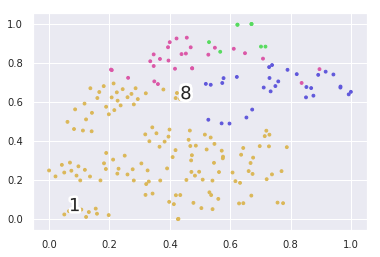

In [201]:
plt_scatter(outlier_feat, labels[sample_idx])

torch.Size([200, 784])
torch.Size([200, 1, 28, 28])


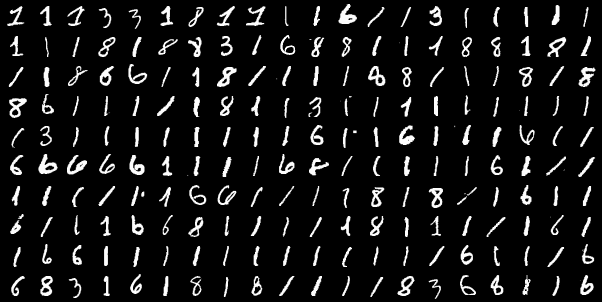

In [202]:
import cv2 as cv
from google.colab.patches import cv2_imshow

outlier_imgs = test_imgs[sample_idx]
print(outlier_imgs.size())
outlier_imgs = outlier_imgs.view(-1, 1, 28, 28)
print(outlier_imgs.size())
save_image(outlier_imgs, OUTPUT_DIR+'/_HDBSCAN_outlier_imgs.png', nrow=20)

outlier_imgs_png = cv.imread(OUTPUT_DIR+'/_HDBSCAN_outlier_imgs.png')
cv2_imshow(outlier_imgs_png)


In [203]:
print(labels[sample_idx].size())
labels[sample_idx].view(-1, 20)


torch.Size([200])


tensor([[1, 1, 1, 3, 3, 1, 8, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, 1, 1],
        [1, 1, 1, 8, 1, 8, 8, 3, 1, 6, 8, 8, 1, 1, 1, 8, 8, 1, 8, 1],
        [1, 1, 8, 6, 6, 1, 1, 8, 1, 1, 1, 1, 8, 8, 1, 1, 1, 8, 1, 8],
        [8, 6, 1, 1, 1, 1, 1, 8, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 6, 1, 1],
        [6, 6, 6, 6, 6, 1, 1, 1, 1, 6, 8, 1, 1, 1, 1, 1, 6, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 8, 1, 8, 1, 1, 6, 1, 1],
        [6, 1, 1, 1, 6, 6, 8, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 6, 1],
        [1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6],
        [6, 8, 3, 1, 6, 1, 8, 1, 8, 1, 1, 1, 1, 8, 3, 6, 8, 1, 1, 6]])

#### Reclustering sample

##### KMeans

In [40]:
from utils.cluster import find_n_clusters_bic

k = find_n_clusters_bic(outlier_feat, OUTPUT_DIR)

4  components


In [0]:

import sklearn.cluster as cluster

kmeans = cluster.KMeans(n_clusters=10, n_init=20, max_iter=100, random_state=SEED)
k_labels = kmeans.fit_predict(outlier_feat)
k_centroids = kmeans.cluster_centers_


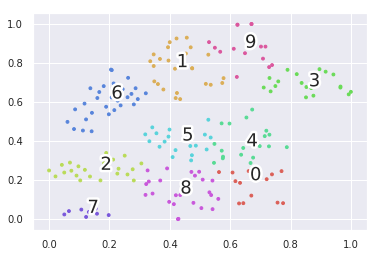

In [205]:
plt_scatter(outlier_feat, k_labels, plt_centroids=False)

In [206]:
cluster_idx = np.array([i[0] for i in sorted(enumerate(k_centroids), key=lambda x:x[1][0])])
cluster_idx

array([7, 2, 6, 5, 1, 8, 9, 4, 0, 3])

In [207]:
len(np.unique(sample_idx))

198

In [108]:
sort_idx = np.array(range(10))
sort_idx
print(k_labels)

[8 6 0 2 8 8 0 8 1 7 7 9 1 8 8 5 1 1 3 4 9 4 6 8 3 3 4 1 5 1 7 3 9 9 5 3 0
 7 7 7 1 5 3 8 4 2 4 3 4 7 9 4 1 0 2 1 9 1 0 5 6 8 3 3 1 3 3 8 9 2 1 4 3 8
 2 0 5 0 9 3 3 1 4 3 7 0 2 2 5 0 2 8 9 1 1 5 1 9 3 5 8 9 4 2 7 6 3 9 5 5 8
 0 8 3 4 7 7 9 5 9 6 2 7 7 9 9 3 1 7 9 1 0 4 5 9 7 0 1 2 6 9 7 5 5 9 4 9 9
 0 8 8 1 0 8 4 7 6 3 5 9 2 7 7 0 4 1 7 5 6 8 1 3 0 2 8 5 6 7 9 8 7 9 5 3 4
 0 7 1 0 8 5 9 5 9 6 6 5 9 9 9]


In [109]:
k_centroids = k_centroids[sort_idx]
k_labels = sort_idx[k_labels]
print(k_labels)

[8 6 0 2 8 8 0 8 1 7 7 9 1 8 8 5 1 1 3 4 9 4 6 8 3 3 4 1 5 1 7 3 9 9 5 3 0
 7 7 7 1 5 3 8 4 2 4 3 4 7 9 4 1 0 2 1 9 1 0 5 6 8 3 3 1 3 3 8 9 2 1 4 3 8
 2 0 5 0 9 3 3 1 4 3 7 0 2 2 5 0 2 8 9 1 1 5 1 9 3 5 8 9 4 2 7 6 3 9 5 5 8
 0 8 3 4 7 7 9 5 9 6 2 7 7 9 9 3 1 7 9 1 0 4 5 9 7 0 1 2 6 9 7 5 5 9 4 9 9
 0 8 8 1 0 8 4 7 6 3 5 9 2 7 7 0 4 1 7 5 6 8 1 3 0 2 8 5 6 7 9 8 7 9 5 3 4
 0 7 1 0 8 5 9 5 9 6 6 5 9 9 9]


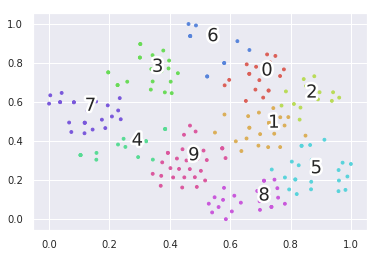

In [117]:
plt_scatter(outlier_feat, cluster_idx[k_labels], plt_centroids=False)

In [38]:


encoded, decoded = ae.forward(test_imgs[sample_idx].view(-1, 784).to(ae.device))
outlier_feat = tsne.fit_transform(encoded.cpu().detach().numpy())
print(outlier_feat.shape)

outlier_feat = StandardScaler().fit_transform(outlier_feat)    # Normalise the data

array([[ 1.7996328 , -0.2623302 ],
       [-0.36561838, -0.66288775],
       [ 0.25432923,  1.432433  ],
       [ 0.5001846 , -1.2002739 ],
       [-1.496232  ,  0.4170963 ],
       [-1.2116579 , -0.84708065],
       [ 0.92141867, -0.19754514],
       [-0.1987634 ,  0.5683115 ],
       [-0.91994333,  1.3239822 ],
       [ 1.4712629 , -1.2784916 ]], dtype=float32)

##### HDBSCAN

In [157]:
# outlier_feat = feat[sample_idx]
hdbscan_outlier = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
hdbscan_outlier.fit(outlier_feat)

print(np.unique(hdbscan_outlier.labels_))
h_outlier_labels = hdbscan_outlier.labels_
h_outlier_labels

[-1  0  1  2  3]


array([ 3, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  1,  3,  1,  0, -1,  3,  3,
        0,  2,  3,  2,  3, -1,  3,  3, -1,  3,  0,  3,  3,  2,  1, -1,  1,
       -1, -1,  3,  3,  3, -1,  3,  2,  3,  3,  0,  3, -1,  3,  3,  3,  3,
        3, -1,  3,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1,  3,  2,
        3,  3,  3,  3,  3,  3,  3,  3, -1,  3,  3,  3, -1,  3,  2,  3, -1,
        3,  3,  1, -1,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1,
        3,  3,  3,  3,  3, -1,  3,  3,  3, -1,  3,  3, -1, -1,  3,  3, -1,
        0,  1,  1,  0,  2,  3,  3,  3,  3,  1,  3, -1,  1,  3, -1,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3, -1,  3,  3,  0,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3, -1,  3,  3,  3,  3,  1,  1,  3,  3,
        3,  3,  3, -1,  0, -1, -1, -1,  0,  3,  3,  3,  3])

Saved /content/drive/My Drive/engr489-2019/kun/models/ae_hdbscan/ae_hdbscan_v1_2019.04.09-11:54:40_output/_HDBSCAN_clusters_outliers.png


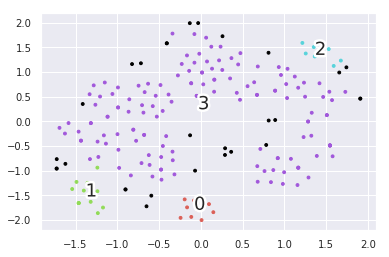

In [158]:
plt_scatter(outlier_feat, h_outlier_labels, plt_name='HDBSCAN_clusters_outliers')

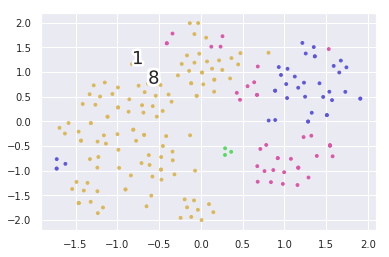

In [159]:
plt_scatter(outlier_feat, labels[sample_idx])

In [160]:
sorted_outliers_idx = np.argsort(h_outlier_labels)
h_outlier_labels[sorted_outliers_idx]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3])

In [161]:
labels[sorted_outliers_idx].view(-1, 20)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 3, 1, 1, 1, 8, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 8, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 6, 1, 1],
        [1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 6, 6, 1, 1, 6, 3],
        [1, 1, 1, 6, 3, 8, 1, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8],
        [1, 1, 1, 1, 6, 1, 1, 1, 3, 1, 1, 1, 1, 1, 6, 8, 1, 1, 1, 8],
        [1, 8, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 1, 3],
        [6, 8, 1, 1, 1, 1, 1, 8, 3, 1, 1, 6, 1, 8, 1, 1, 1, 1, 8, 1],
        [1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 8, 6, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 3, 1, 3, 3, 1, 1, 1, 1]])

#### Reorder grid

In [180]:
centroids = np.array([np.median(outlier_feat[h_outlier_labels == label, :], axis=0) for label in np.unique(h_outlier_labels)[1:]])
centroid_imgs_idx, _ = pairwise_distances_argmin_min(centroids, outlier_feat)
print(test_imgs.size())
print(centroid_imgs_idx)

torch.Size([2101, 784])
[126 182  23   3  86]


torch.Size([5, 784])
torch.Size([5, 1, 28, 28])


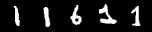

In [182]:
import cv2 as cv
from google.colab.patches import cv2_imshow

centroid_imgs =  test_imgs[centroid_imgs_idx]
print(centroid_imgs.size())
centroid_imgs = centroid_imgs.view(-1, 1, 28, 28)
print(centroid_imgs.size())
save_image(centroid_imgs, OUTPUT_DIR+'/_outlier_centroid_imgs_{}.png'.format(ae.EPOCH))


centroid_imgs_png = cv.imread(OUTPUT_DIR+'/_outlier_centroid_imgs_{}.png'.format(ae.EPOCH))
cv2_imshow(centroid_imgs_png)


In [170]:
print(h_outlier_labels)
sample_idx

[-1  3  5  2  0  0  3 -1  4  6 -1  3  4  5  0  0  5  0  6  0  3  0 -1 -1
 -1 -1 -1 -1  3  7  2  3  0  4  0  4  3  2  0  3  1 -1  2  3  2  1  0  1
  1  2  1  2  6 -1  0  3 -1  0  0  1  5  5  3  3  2  3  5  4  1  4  3  0
  0  2  4  0  3  6  4  1  0 -1  0  4  7  3  3  1 -1  4  3  2  3  7  6  3
  1  0  1 -1  0  6  1  6  3  6  0  1  3  3  6  6 -1  1  2  3  4  0  3  5
  3  3  4  0  0 -1  0  3 -1  0  0  2  4 -1  1  1  5  1  4  2  7  0 -1  2
  3  0  2  0  0  2 -1  1  0  7 -1  1  5  1  7  0  2  3  1  2  6  1 -1  3
  1  1  2  0  5  0 -1  1  3  1  6 -1  4  4  1 -1  1  3  5  3  0  5  1  1
  4  0 -1 -1  2  2  2  1]


array([ 999, 1209,   86,  650, 1543,  791, 1738, 1304,  918, 1827, 1062,
        959,  243, 1820, 1111,  923,  236, 1273, 1932, 1497,  959,  422,
       2072, 1064,  568, 1850, 1304, 1304,  929,  887, 1278,  991, 2019,
       1223,  923,  243,  411, 1606, 1273,  780,  515, 1064,   52, 1209,
       2059, 1482, 1273, 1948,  498, 1566,    8, 2016, 1964, 2098,  229,
        929,  999,  422, 1703,  168, 1937,   86, 1115,  991, 1566,  959,
       1852, 1428, 1272, 1961,  900, 1103, 1599, 1919,  243, 1542,  802,
        403, 1035, 1530,  260, 1064, 1543,  376,  887, 1115,  485, 1272,
       1470, 1428,  485, 1166,  751, 1845, 1932,  386, 1944, 1497, 1944,
        203,  146, 1932,   17,  938,  780,  938, 1111, 1944,  757, 1738,
       1964, 1932,  999, 1944, 1794, 1489, 1223,  220,  485,  859, 1090,
       1208, 1035, 1542,  662,  624,  321,  959, 1836, 1497, 1799, 1140,
        918,  252, 1944, 1439, 1937,  314,  376, 1566, 1845,  146,  210,
       1140, 1489, 2065,  739, 1599,  891, 1166, 16

In [153]:
sorted(sample_idx, key=lambda x:(x[1]))[::-1]

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]